# Simulate a Dataset
* Assume we have a query $x$, to which we elicit different responses $y_i$.
* The responses are e.g. letters from A to Z. So $n = 25$.
* They are ordered in a random, but specific order.
* We draw 100 pairwise comparisons
* The query $x$ is assumed to be constant, so we will disregard it in the simulation.
* The reward $r(y, x)$ becomes $r(y)$. Its value is hard-coded to be $n - position(y)$, e.g. if C is the 24th letter in the order, then
$$
r(C) = 25 - 24 = 1
$$

In [1]:
import string
import random

letters = list(string.ascii_uppercase)
n = len(letters)

In [2]:
shuffled = list(letters)
random.seed(0)
random.shuffle(shuffled)

letter2r = {l: n - idx for idx, l in enumerate(shuffled, 1)}
assert letter2r["A"] == n - 2
assert letter2r["B"] == n - 23

In [3]:
letter2r

{'O': 25,
 'A': 24,
 'X': 23,
 'S': 22,
 'G': 21,
 'F': 20,
 'H': 19,
 'K': 18,
 'W': 17,
 'U': 16,
 'E': 15,
 'C': 14,
 'V': 13,
 'D': 12,
 'R': 11,
 'L': 10,
 'T': 9,
 'J': 8,
 'Z': 7,
 'P': 6,
 'Q': 5,
 'I': 4,
 'B': 3,
 'N': 2,
 'Y': 1,
 'M': 0}

In [4]:
from math import exp

def p_star(y1, y2) -> float:
    r1 = letter2r[y1]
    r2 = letter2r[y2]
    return exp(r1) / (exp(r1) + exp(r2))

assert p_star("A", "A") == .5
assert p_star("O", "A") > p_star("A", "O")

In [5]:
import pandas as pd
import numpy as np

# draw pairs for comparison
random.seed(0)
n_pairs = 1000
D = [random.choices(letters, k=2) for _ in range(n_pairs)]
assert len(D) == n_pairs

# Add p* to pair
D = [(y1, y2, p_star(y1, y2)) for y1, y2 in D]

df = pd.DataFrame(D, columns=["y1", "y2", "p*"])
np.random.seed(0)
df["random"] = np.random.random(size=len(df))
df["yw"] = np.where(df["random"] < df["p*"], df["y1"], df["y2"])
df["yl"] = np.where(df["random"] < df["p*"], df["y2"], df["y1"])
df.head()

,y1,y2,p*,random,yw,yl
0,V,T,9.820138e-01,0.548814,V,T
1,K,G,4.742587e-02,0.715189,G,K
2,N,K,1.125352e-07,0.602763,K,N
3,U,H,4.742587e-02,0.544883,H,U
4,M,P,2.472623e-03,0.423655,P,M


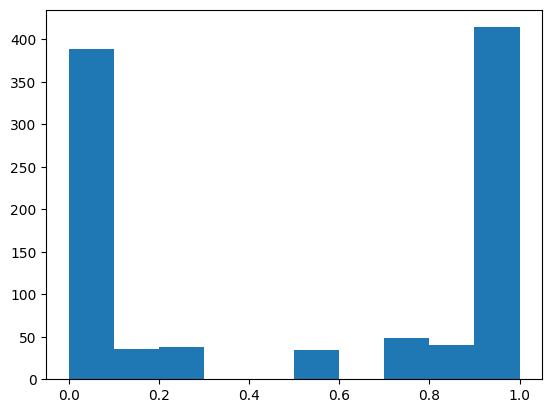

In [6]:
import matplotlib.pyplot as plt

plt.hist(df["p*"])
plt.show()

# Define a Model for $r_{\theta}(y)$
* The training data is only pairwise comparisons with winner and loser $(y_w, y_l)$
* Our model must outputs the prediction $r_{\theta}(y)$, and has parameters $\theta$.
* $\theta$ has as many dimensions as there are letters, and each parameter encodes the predicted value of $r$ for each letter.

In [7]:
df_train = df[["yw", "yl"]]
df_train.head()

,yw,yl
0,V,T
1,G,K
2,K,N
3,H,U
4,P,M


In [8]:
import torch
from torch import nn

class Ranker(nn.Module):
    def __init__(self):
        super().__init__()
        self.params = nn.Parameter(torch.zeros(len(letters)))

    def forward(self, letters):  # B x n
        # ps = self.params - self.params.max() + 1  # normalize s.t. the highest entry is 1.
        rs = letters @ self.params  # B x 1
        return rs

    def ordered_letters(self) -> list[str]:
        params2letters = sorted(zip(self.params.detach().numpy(), letters), reverse=True)
        return [letter for param, letter in params2letters]

r = Ranker()

In [9]:
# Encode letters as one-hot vectors
vecs = torch.eye(len(letters))

letter2vec = dict(zip(letters, vecs))

letter2vec["Z"]

def encode(ls: list[str]) -> torch.Tensor:
    return torch.stack([letter2vec[l] for l in ls])

encode(["A", "B", "C"])

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]])

In [10]:
r(encode(["A", "B", "C"]))
r(encode(df_train["yw"]))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

# Define a Loss, Evaluation Metric

In [11]:
def loss(r_w_pred, r_l_pred) -> torch.Tensor:
    return -torch.sigmoid(r_w_pred - r_l_pred).log().mean()

In [12]:
from scipy.stats import kendalltau

def kt(m: Ranker) -> float:
    return kendalltau(m.ordered_letters(), shuffled).statistic

kt(r)

-0.06461538461538462

# Train the Model

In [13]:
model = Ranker()
opt = torch.optim.Adam(lr=.1, params=model.parameters())

kendall_taus = []
for _ in range(40):
    opt.zero_grad()
    r_w_pred = model(encode(df_train["yw"]))
    r_l_pred = model(encode(df_train["yl"]))
    l = loss(r_w_pred, r_l_pred)
    kendall_taus.append(kt(model))
    print("loss:", l.item())
    l.backward()
    opt.step()

loss: 0.6931473612785339
loss: 0.6450828909873962
loss: 0.6019250750541687
loss: 0.5634477734565735
loss: 0.5291073322296143
loss: 0.49837028980255127
loss: 0.4708543121814728
loss: 0.44623804092407227
loss: 0.424213171005249
loss: 0.40449291467666626
loss: 0.3868195414543152
loss: 0.3709484040737152
loss: 0.3566393256187439
loss: 0.3436663746833801
loss: 0.33183753490448
loss: 0.32100409269332886
loss: 0.3110535740852356
loss: 0.3018949627876282
loss: 0.29344767332077026
loss: 0.2856380045413971
loss: 0.2784004211425781
loss: 0.2716788649559021
loss: 0.26542598009109497
loss: 0.2596006989479065
loss: 0.2541661262512207
loss: 0.24908892810344696
loss: 0.24433963000774384
loss: 0.2398931086063385
loss: 0.23572781682014465
loss: 0.23182427883148193
loss: 0.22816362977027893
loss: 0.22472691535949707
loss: 0.221495121717453
loss: 0.21844987571239471
loss: 0.2155739665031433
loss: 0.21285147964954376
loss: 0.21026824414730072
loss: 0.20781171321868896
loss: 0.2054709941148758
loss: 0.20323

In [14]:
res_df = pd.DataFrame(dict(order=shuffled, pred_order=model.ordered_letters()))
res_df["correct"] = res_df["order"] == res_df["pred_order"]
res_df

,order,pred_order,correct
0,O,O,True
1,A,A,True
2,X,X,True
3,S,S,True
4,G,G,True
5,F,H,False
6,H,F,False
7,K,K,True
8,W,W,True
9,U,U,True


In [15]:
res_df["correct"].mean()

0.7692307692307693

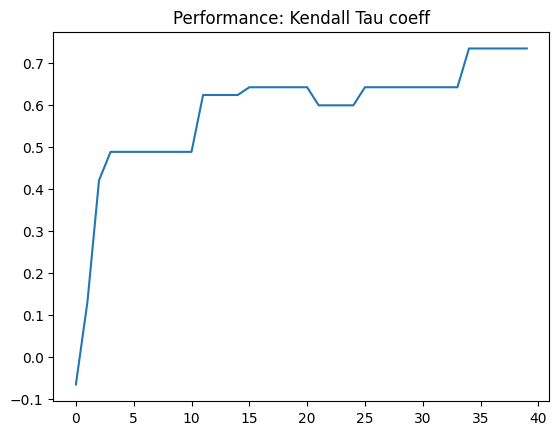

In [16]:
plt.title("Performance: Kendall Tau coeff")
plt.plot(kendall_taus)
plt.show()